In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


# Mengubah parameter default matplotlib
Parameter default matplotlib dapat diubah dengan rcParams sebagai berikut

In [2]:
from matplotlib import rcParams

rcParams['figure.figsize'] = 12, 4
rcParams['lines.linewidth'] = 3
rcParams['xtick.labelsize'] = 'x-large'
rcParams['ytick.labelsize'] = 'x-large'

# Load dataset

Untuk hands-on kita akan melihat dataset sintetik prediksi kebotakan. Agar running time-nya tidak terlalu lama, kali ini kita ambil sampel 1000 baris data saja.

In [3]:
df = pd.read_csv('Churn_Modelling.csv')

# Descriptive Statistics

## Memeriksa kolom-kolom dan nilai hilang dengan `df.info()`

Hal pertama yang biasanya dilakukan dalam EDA adalah mengecek tipe data setiap kolom dan jumlah nilai yang hilang. Hal ini bisa kita lakukan dengan menggunakan `df.info()`.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


## Sampling untuk memahami data dengan `df.sample()`

In [5]:
df

RowNumber  CustomerId    Surname  CreditScore Geography  Gender  Age  \
0             1    15634602   Hargrave          619    France  Female   42   
1             2    15647311       Hill          608     Spain  Female   41   
2             3    15619304       Onio          502    France  Female   42   
3             4    15701354       Boni          699    France  Female   39   
4             5    15737888   Mitchell          850     Spain  Female   43   
...         ...         ...        ...          ...       ...     ...  ...   
9995       9996    15606229   Obijiaku          771    France    Male   39   
9996       9997    15569892  Johnstone          516    France    Male   35   
9997       9998    15584532        Liu          709    France  Female   36   
9998       9999    15682355  Sabbatini          772   Germany    Male   42   
9999      10000    15628319     Walker          792    France  Female   28   

      Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0          2       0.00              1          1               1   
1          1   83807.86              1          0               1   
2          8  159660.80              3          1               0   
3          1       0.00              2          0               0   
4          2  125510.82              1          1               1   
...      ...        ...            ...        ...             ...   
9995       5       0.00              2          1               0   
9996      10   57369.61              1          1               1   
9997       7       0.00              1          0               1   
9998       3   75075.31              2          1               0   
9999       4  130142.79              1          1               0   

      EstimatedSalary  Exited  
0           101348.88       1  
1           112542.58       0  
2           113931.57       1  
3            93826.63       0  
4            79084.10       0  
...               ...     ...  
9995         96270.64       0  
9996        101699.77       0  
9997         42085.58       1  
9998         92888.52       1  
9999         38190.78       0  

[10000 rows x 14 columns]

## CLEANSING DATASET

In [6]:
## drop kolom RowNumber
df.drop(["RowNumber", "CustomerId", "Surname"], axis=1, inplace=True)

In [7]:
## Ubah Tipe data kolom
columns_to_convert = ['IsActiveMember', 'HasCrCard', 'Exited','NumOfProducts']
df[columns_to_convert] = df[columns_to_convert].astype(object)

In [8]:
# pengelompokan kolom berdasarkan jenisnya
cats = ['Geography', 'Gender','IsActiveMember', 'HasCrCard', 'Exited','NumOfProducts']
nums = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']

In [9]:
df[nums].describe()

CreditScore           Age        Tenure        Balance  \
count  10000.000000  10000.000000  10000.000000   10000.000000   
mean     650.528800     38.921800      5.012800   76485.889288   
std       96.653299     10.487806      2.892174   62397.405202   
min      350.000000     18.000000      0.000000       0.000000   
25%      584.000000     32.000000      3.000000       0.000000   
50%      652.000000     37.000000      5.000000   97198.540000   
75%      718.000000     44.000000      7.000000  127644.240000   
max      850.000000     92.000000     10.000000  250898.090000   

       EstimatedSalary  
count     10000.000000  
mean     100090.239881  
std       57510.492818  
min          11.580000  
25%       51002.110000  
50%      100193.915000  
75%      149388.247500  
max      199992.480000

In [10]:
df[cats].describe()

Geography Gender  IsActiveMember  HasCrCard  Exited  NumOfProducts
count      10000  10000           10000      10000   10000          10000
unique         3      2               2          2       2              4
top       France   Male               1          1       0              1
freq        5014   5457            5151       7055    7963           5084

In [11]:
df.isna().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

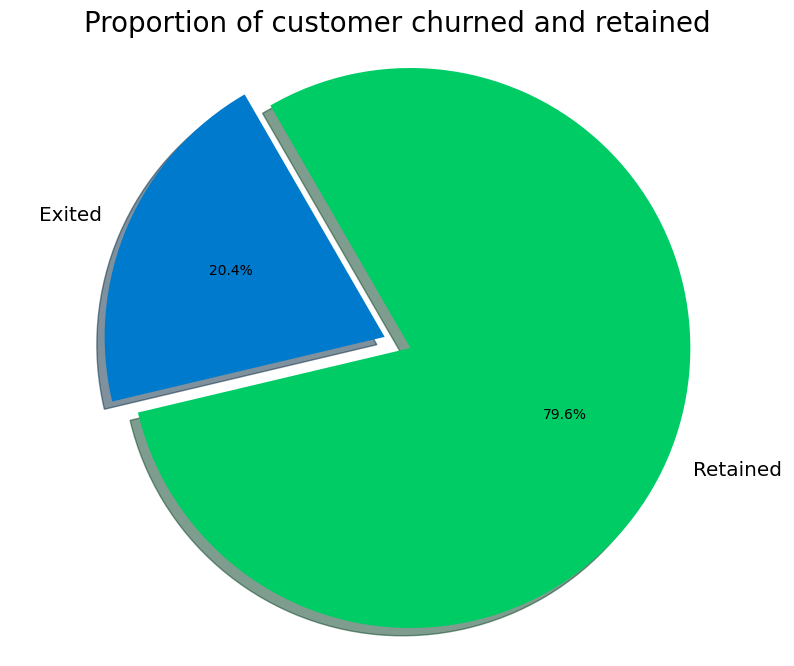

In [12]:
# Menghitung jumlah kasus untuk setiap kategori dalam 'Exited'
sizes = [df.Exited[df['Exited']==1].count(), df.Exited[df['Exited']==0].count()]
labels = 'Exited', 'Retained'
explode = (0, 0.1)  # untuk menonjolkan slice pie
warna = ['#007acc', '#00cc66']

# Membuat pie chart
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=120, colors=warna)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Proportion of customer churned and retained", size = 20)
plt.show()


Pada Dataset ini sebagian besar customer tidak mengalami churn sehingga dapat mengurangi akurasi pembuatan model machine learrning


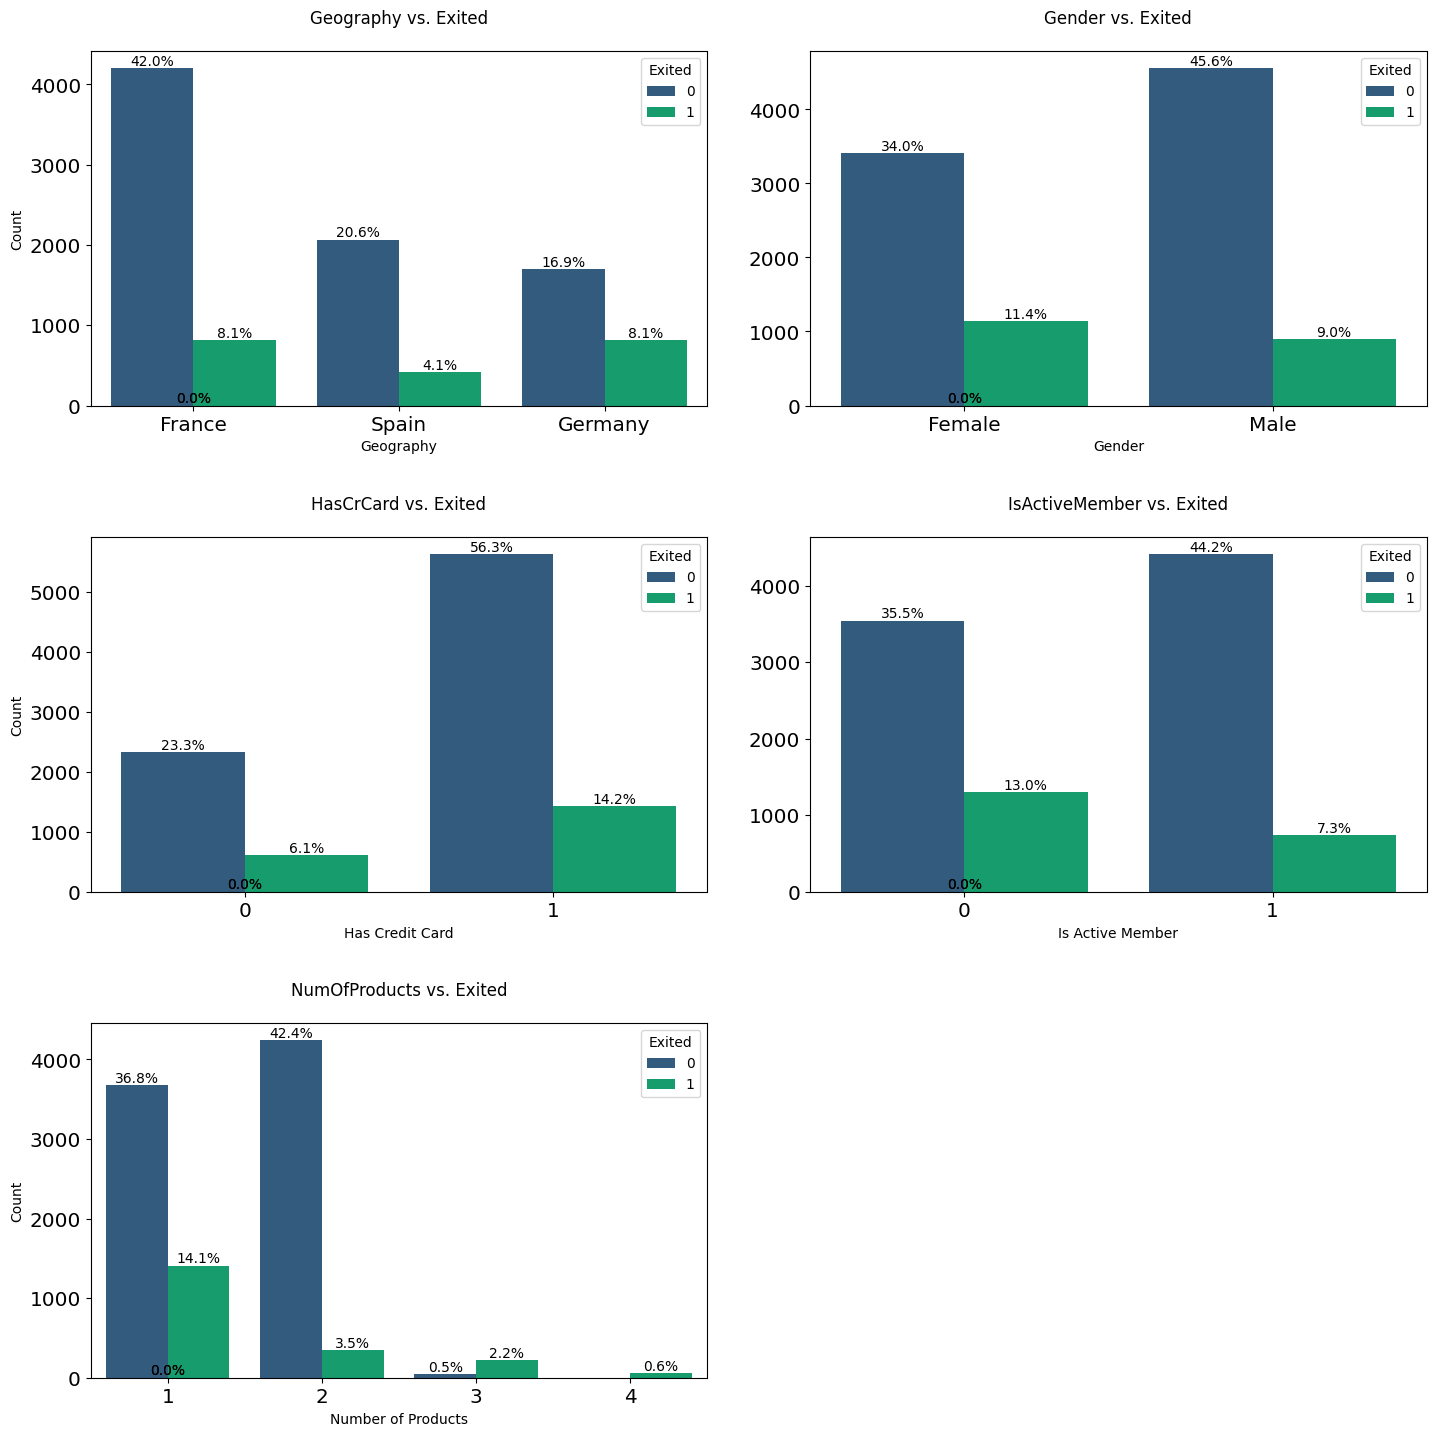

In [13]:

# Definisikan palet warna
palet_warna = ["#265c8b", "#00b274"]

# Membuat plot 3x2
fig, axarr = plt.subplots(3, 2, figsize=(15, 15))

# Plot 1 - Geografi
sns.countplot(x='Geography', hue='Exited', data=df, ax=axarr[0, 0], palette=palet_warna, dodge=True)
axarr[0, 0].set_title('Geography vs. Exited', pad=20)
axarr[0, 0].set_xlabel('Geography')
axarr[0, 0].set_ylabel('Count')
axarr[0, 0].legend(title='Exited', loc='upper right')

# Tambahkan label persentase
total_data_geography = df['Geography'].count()
for p in axarr[0, 0].patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total_data_geography)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    axarr[0, 0].annotate(percentage, (x, y), ha='center', va='bottom')

# Plot 2 - Gender
sns.countplot(x='Gender', hue='Exited', data=df, ax=axarr[0, 1], palette=palet_warna, dodge=True)
axarr[0, 1].set_title('Gender vs. Exited', pad=20)
axarr[0, 1].set_xlabel('Gender')
axarr[0, 1].set_ylabel('')
axarr[0, 1].legend(title='Exited', loc='upper right')

# Tambahkan label persentase
total_data_gender = df['Gender'].count()
for p in axarr[0, 1].patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total_data_gender)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    axarr[0, 1].annotate(percentage, (x, y), ha='center', va='bottom')

# Plot 3 - HasCrCard
sns.countplot(x='HasCrCard', hue='Exited', data=df, ax=axarr[1, 0], palette=palet_warna, dodge=True)
axarr[1, 0].set_title('HasCrCard vs. Exited', pad=20)
axarr[1, 0].set_xlabel('Has Credit Card')
axarr[1, 0].set_ylabel('Count')
axarr[1, 0].legend(title='Exited', loc='upper right')

# Tambahkan label persentase
total_data_has_cr_card = df['HasCrCard'].count()
for p in axarr[1, 0].patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total_data_has_cr_card)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    axarr[1, 0].annotate(percentage, (x, y), ha='center', va='bottom')

# Plot 4 - IsActiveMember
sns.countplot(x='IsActiveMember', hue='Exited', data=df, ax=axarr[1, 1], palette=palet_warna, dodge=True)
axarr[1, 1].set_title('IsActiveMember vs. Exited', pad=20)
axarr[1, 1].set_xlabel('Is Active Member')
axarr[1, 1].set_ylabel('')
axarr[1, 1].legend(title='Exited', loc='upper right')

# Tambahkan label persentase
total_data_is_active_member = df['IsActiveMember'].count()
for p in axarr[1, 1].patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total_data_is_active_member)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    axarr[1, 1].annotate(percentage, (x, y), ha='center', va='bottom')

# Plot 5 - NumOfProducts
sns.countplot(x='NumOfProducts', hue='Exited', data=df, ax=axarr[2, 0], palette=palet_warna, dodge=True)
axarr[2, 0].set_title('NumOfProducts vs. Exited', pad=20)
axarr[2, 0].set_xlabel('Number of Products')
axarr[2, 0].set_ylabel('Count')
axarr[2, 0].legend(title='Exited', loc='upper right')

# Tambahkan label persentase
total_data_num_of_products = df['NumOfProducts'].count()
for p in axarr[2, 0].patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total_data_num_of_products)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    axarr[2, 0].annotate(percentage, (x, y), ha='center', va='bottom')

# Hapus subplot yang tidak digunakan
fig.delaxes(axarr[2, 1])

plt.tight_layout(pad=3.0)
plt.show()


1. Sebagian besar Customer adalah laki laki.
2. Untuk Customer perempuan paling banyak yang mengalami churn.
3. Sebagian besar Customer berasal dari France.
4. Customer yang berasal dari German paling banyak yang mengalami churn atau berhenti berlangganan.
5. Customer memiliki credit card cenderung mengalami churn.
6. Sebagian besar Customer merupakan member aktif yang berdasarkan dataset tersebut hanya sebagian kecil yang mengalami churn.






In [14]:
for col in cats:
    print(f'''Value count kolom {col}:''')
    print(df[col].value_counts())
    print()

Value count kolom Geography:
Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64

Value count kolom Gender:
Gender
Male      5457
Female    4543
Name: count, dtype: int64

Value count kolom IsActiveMember:
IsActiveMember
1    5151
0    4849
Name: count, dtype: int64

Value count kolom HasCrCard:
HasCrCard
1    7055
0    2945
Name: count, dtype: int64

Value count kolom Exited:
Exited
0    7963
1    2037
Name: count, dtype: int64

Value count kolom NumOfProducts:
NumOfProducts
1    5084
2    4590
3     266
4      60
Name: count, dtype: int64



c:\Users\dekdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:1601: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))
c:\Users\dekdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:1601: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))
c:\Users\dekdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:1601: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))
c:\Users\dekdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:1601: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))
c:\Users\dekdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:16

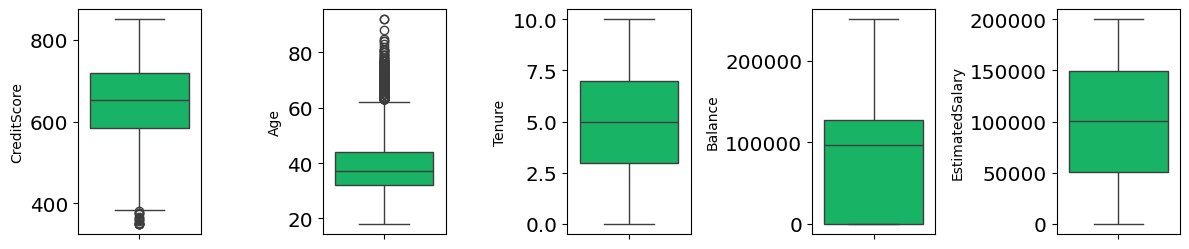

In [15]:

pallet1 = '#00cc66'  # Atau warna spesifik yang Anda inginkan

plt.figure(figsize=(12, 5))
for i in range(0, len(nums)):
    plt.subplot(2, len(nums), i+1)
    sns.boxplot(y=df[nums[i]] ,color=pallet1, orient='h')  
    plt.tight_layout()
plt.show()



1. Pada Boxplot credit score dan age teridentifikasi outlier
2. Pada Boxplot balance terdapat gap data minimum dan maksimum sehingga cenderung miring ke kanan(positive skewness).
3. Pada Boxplot estimated salary data berdistribusi normal.


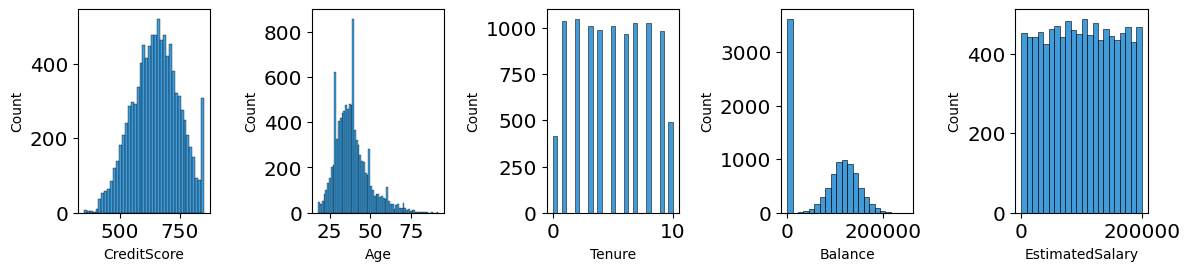

In [16]:
plt.figure(figsize=(12, 5))
for i in range(0, len(nums)):
    plt.subplot(2, len(nums), i+1)
    sns.histplot(df[nums[i]], color=warna[0])
    plt.tight_layout()

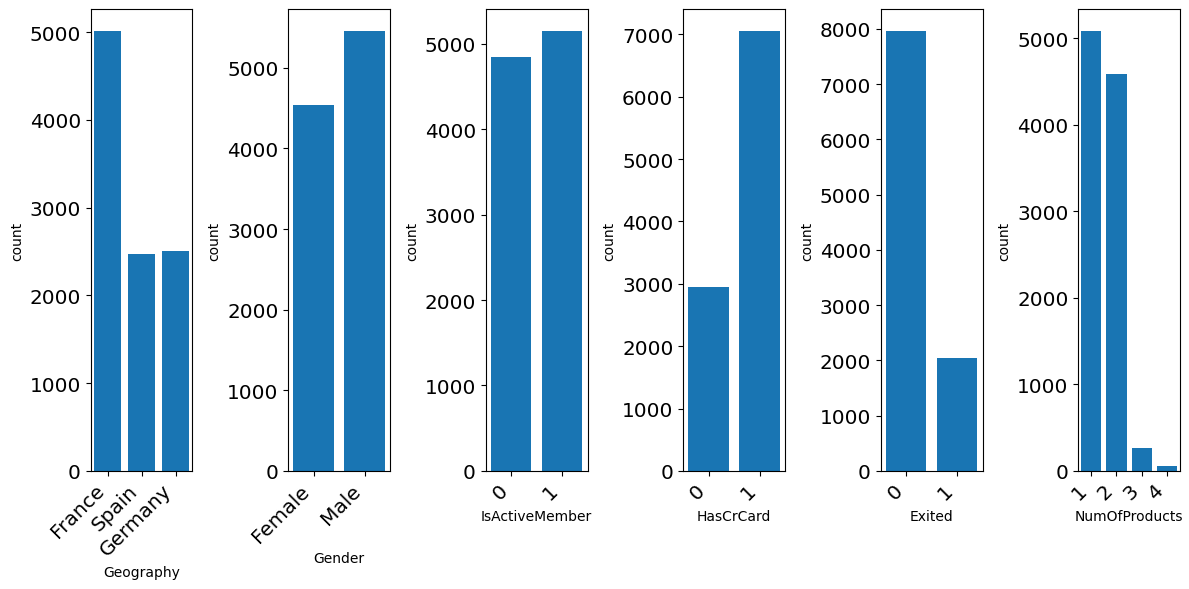

In [18]:
plt.figure(figsize=(12, 6))  # Menyesuaikan ukuran plot
for i in range(0, len(cats)):
    plt.subplot(1, len(cats), i+1)
    sns.countplot(x=df[cats[i]], color=warna[0])
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()  # Memanggil fungsi ini dengan benar

plt.show()

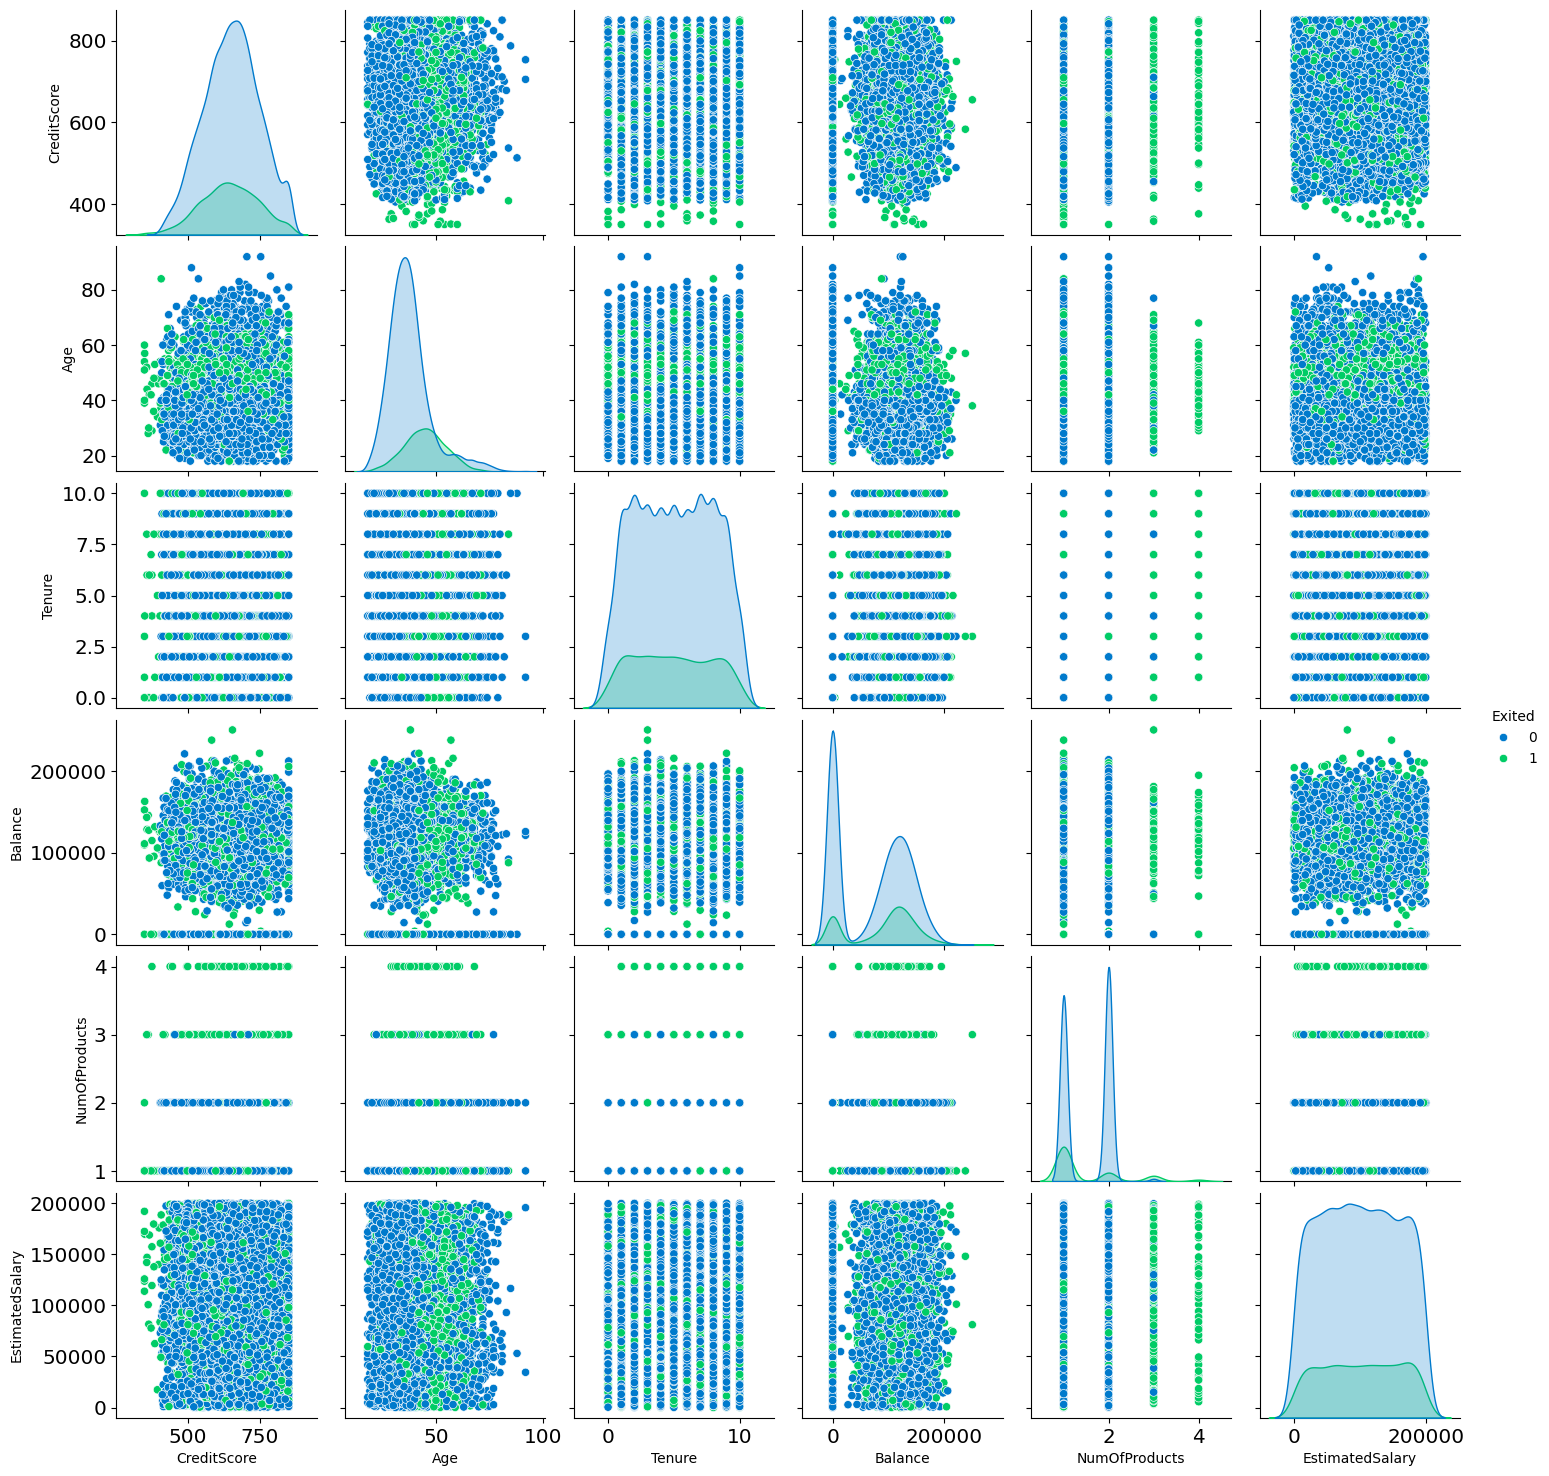

In [19]:
# Selecting columns that are potentially more relevant for predicting churn
selected_columns = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'Exited']

# Creating a new DataFrame with the selected columns
data_selected = df[selected_columns]

# Creating pair plots for the selected columns, grouped by 'Exited'
sns.pairplot(data_selected, hue='Exited', palette=warna, diag_kind="kde")
plt.show()


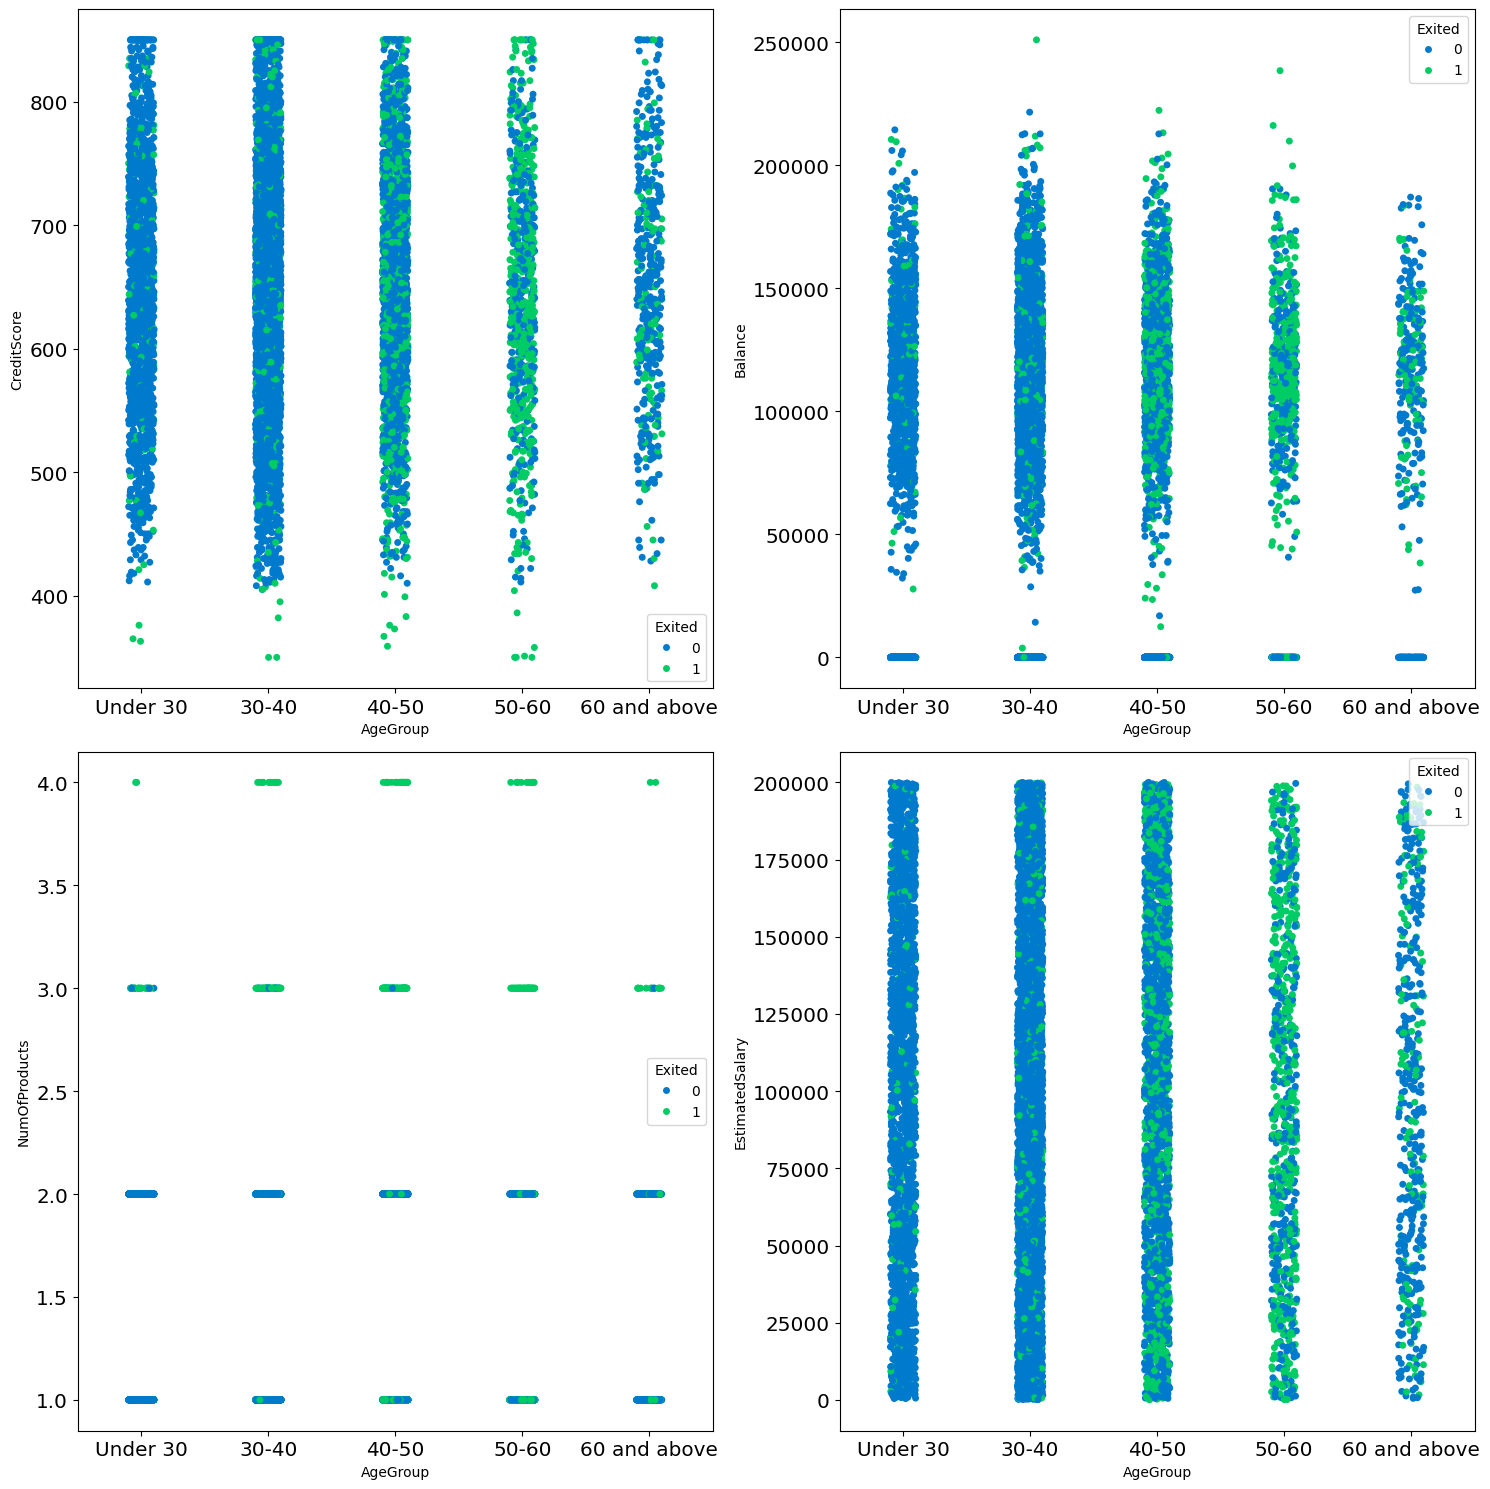

In [20]:
# Membuat kategori umur
bins = [0, 30, 40, 50, 60, float('inf')]
labels = ['Under 30', '30-40', '40-50', '50-60', '60 and above']
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels)

# Pilih kolom numerik saja
nums = ['CreditScore', 'Balance', 'NumOfProducts', 'EstimatedSalary']  # Memilih kolom numerik relevan

# Membuat plot
fig = plt.figure(figsize=(15, 15))
for i, col in enumerate(nums):
    ax = fig.add_subplot(2, 2, i+1)  # Set posisi plot
    sns.stripplot(ax=ax, data=df, x='AgeGroup', y=col, hue='Exited', palette=warna)
    plt.tight_layout()

plt.show()


Untuk mempermudah observasi, dilakukan grouping berdasarkan rentang umur, terlihat pada rentang umur 50-60 tahun customer cenderung mengalami churn.

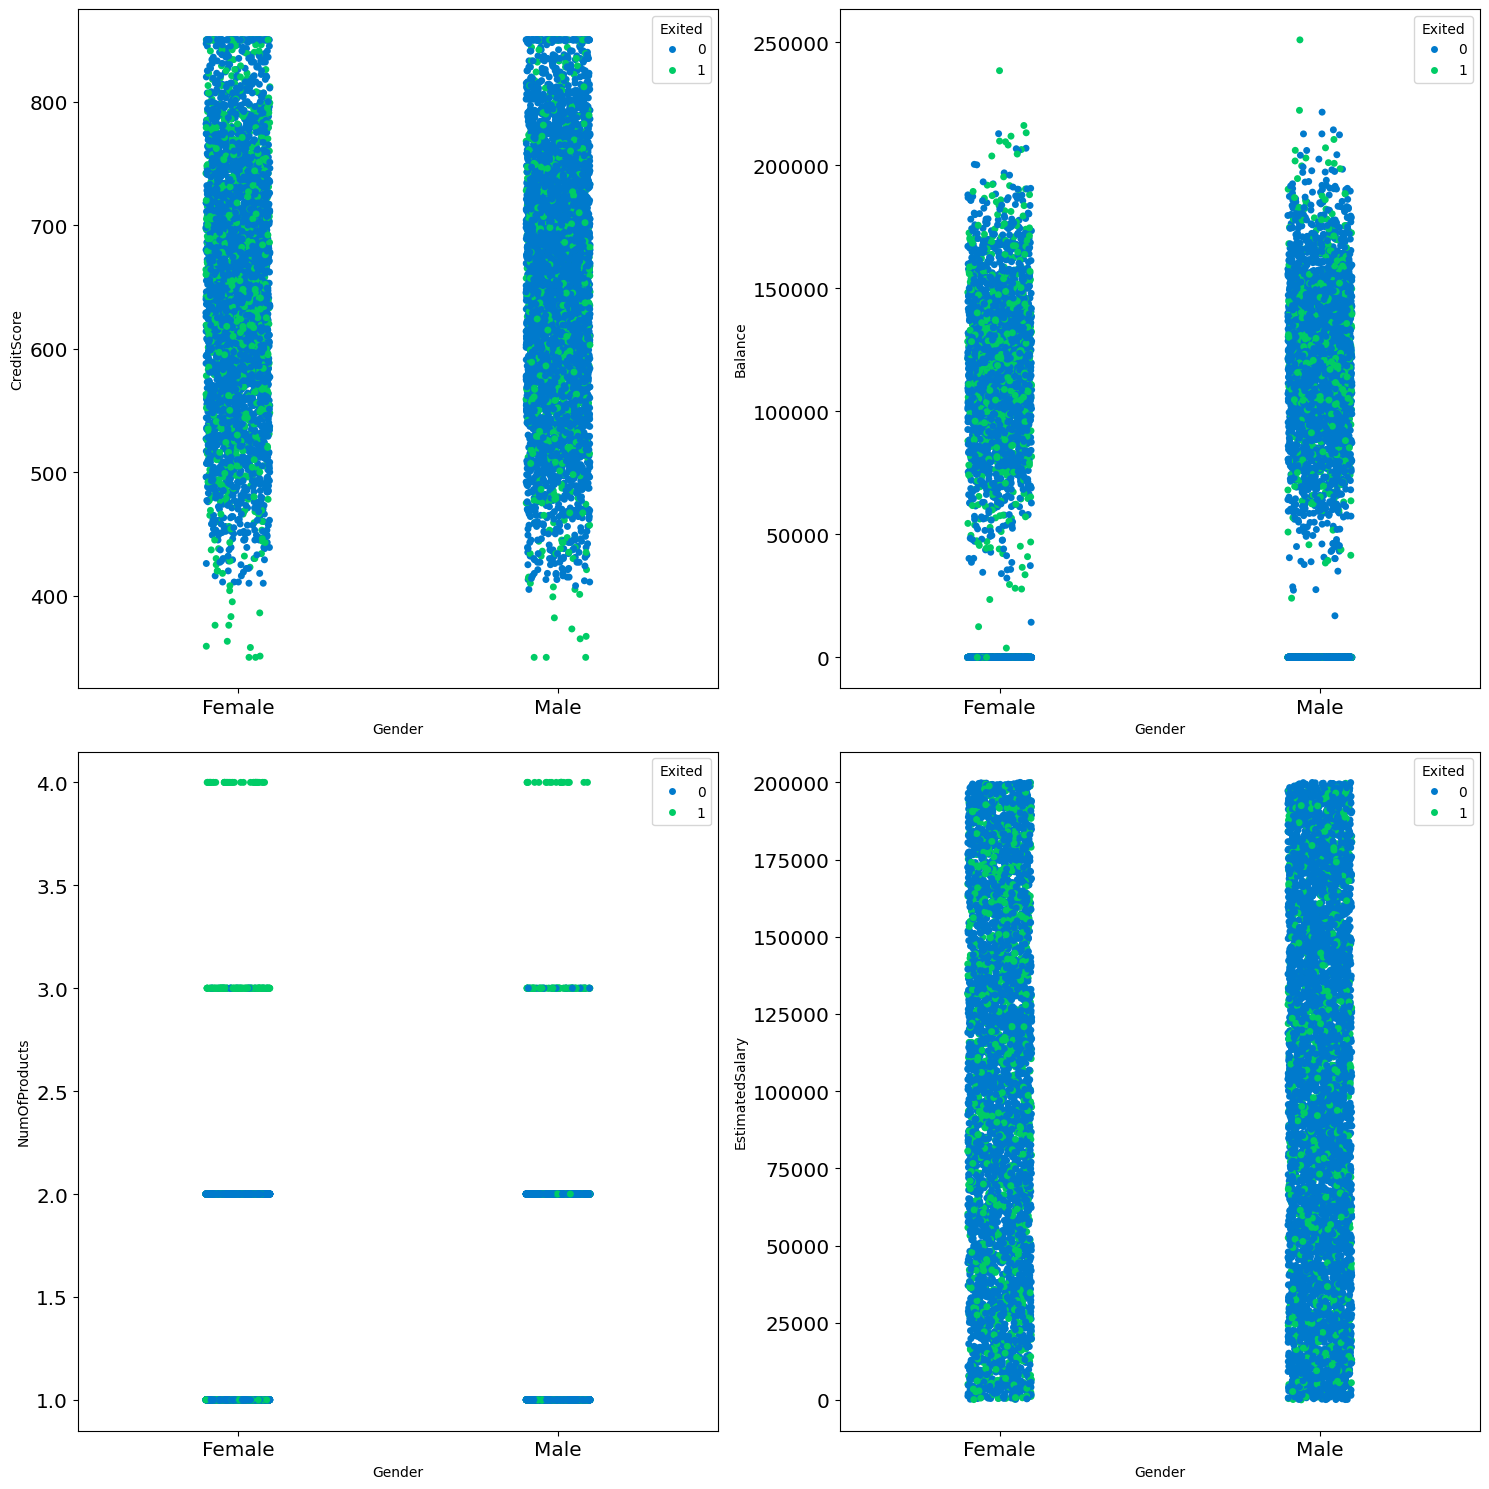

In [21]:
# Mengatur ulang variabel numerik yang akan diplot
nums = ['CreditScore', 'Balance', 'NumOfProducts', 'EstimatedSalary'] 

# Membuat plot
fig = plt.figure(figsize=(15, 15))
for i, col in enumerate(nums):
    ax = fig.add_subplot(2, 2, i+1)  # Set posisi plot
    sns.stripplot(ax=ax, data=df, x='Gender', y=col, hue='Exited', palette=warna)
    plt.tight_layout()

plt.show()


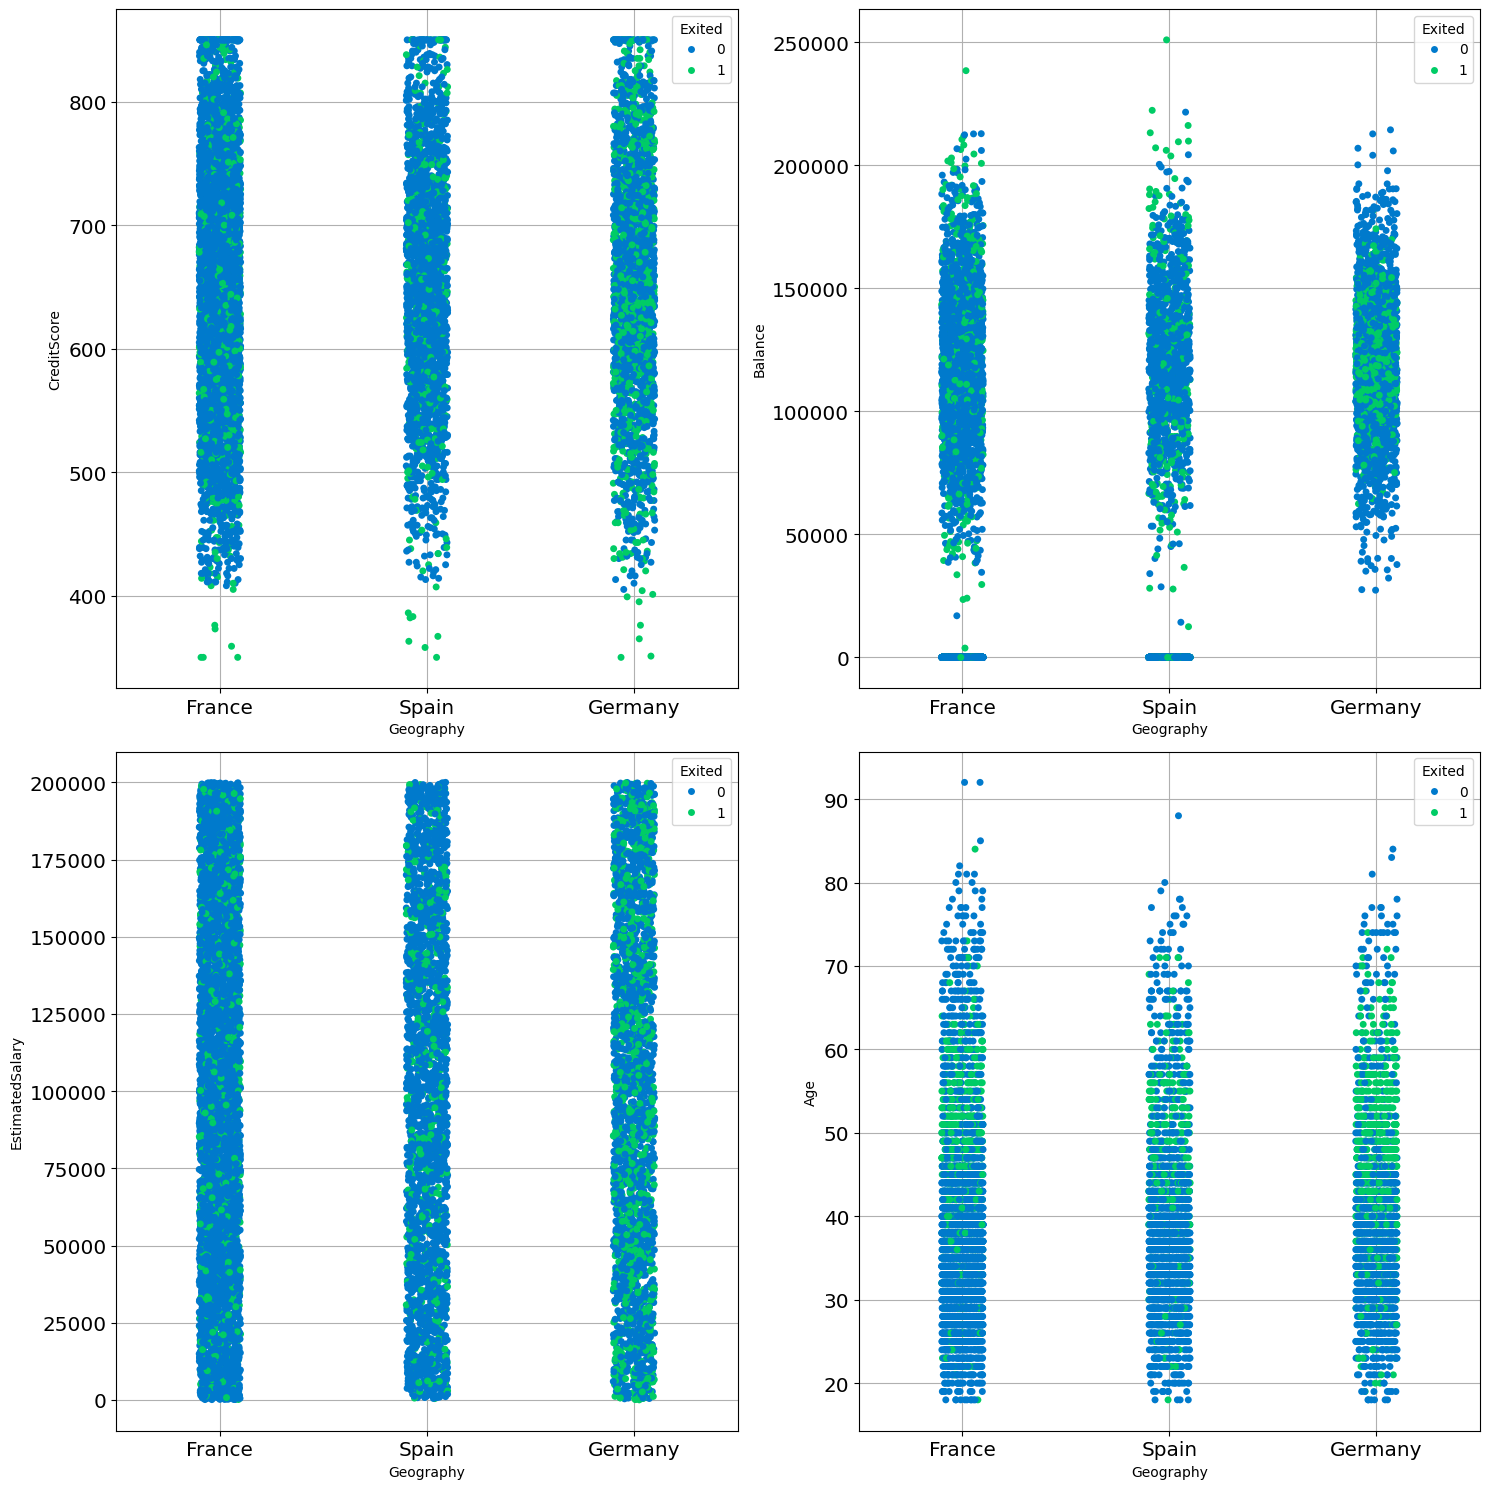

In [22]:
# Pastikan 'Geography' diolah sebagai data kategoris
df['Geography'] = df['Geography'].astype(object)

# Mengatur ulang variabel numerik yang akan diplot
nums = ['CreditScore', 'Balance', 'EstimatedSalary', 'Age']

# Membuat plot
fig = plt.figure(figsize=(15, 15))
for i, col in enumerate(nums):
    ax = fig.add_subplot(2, 2, i+1)  # Set posisi plot
    sns.stripplot(ax=ax, data=df, x='Geography', y=col, hue='Exited', palette=warna)
    ax.grid(True)
    plt.tight_layout()

plt.show()


Jika dilakukan pengecekkan data, jumlah data untuk num of product 1, 2, 3 dan 4 tidak merata, sehingga kami memecah pair plot agar terlihat bagaimana pengaruh num of product terhadap churn.

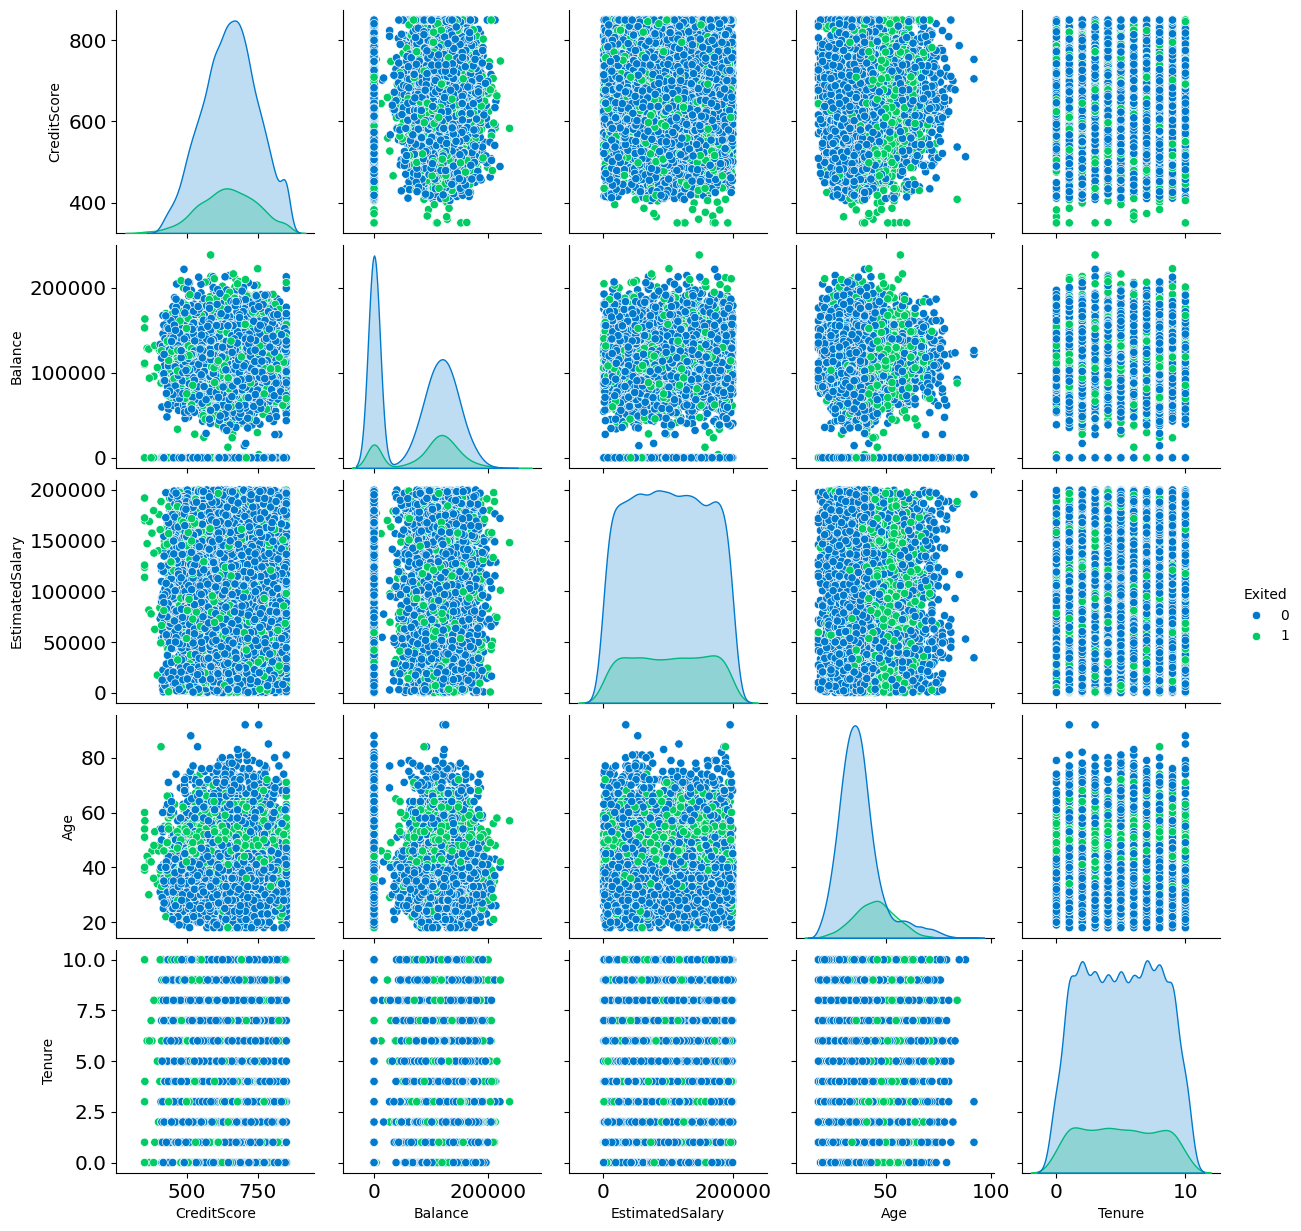

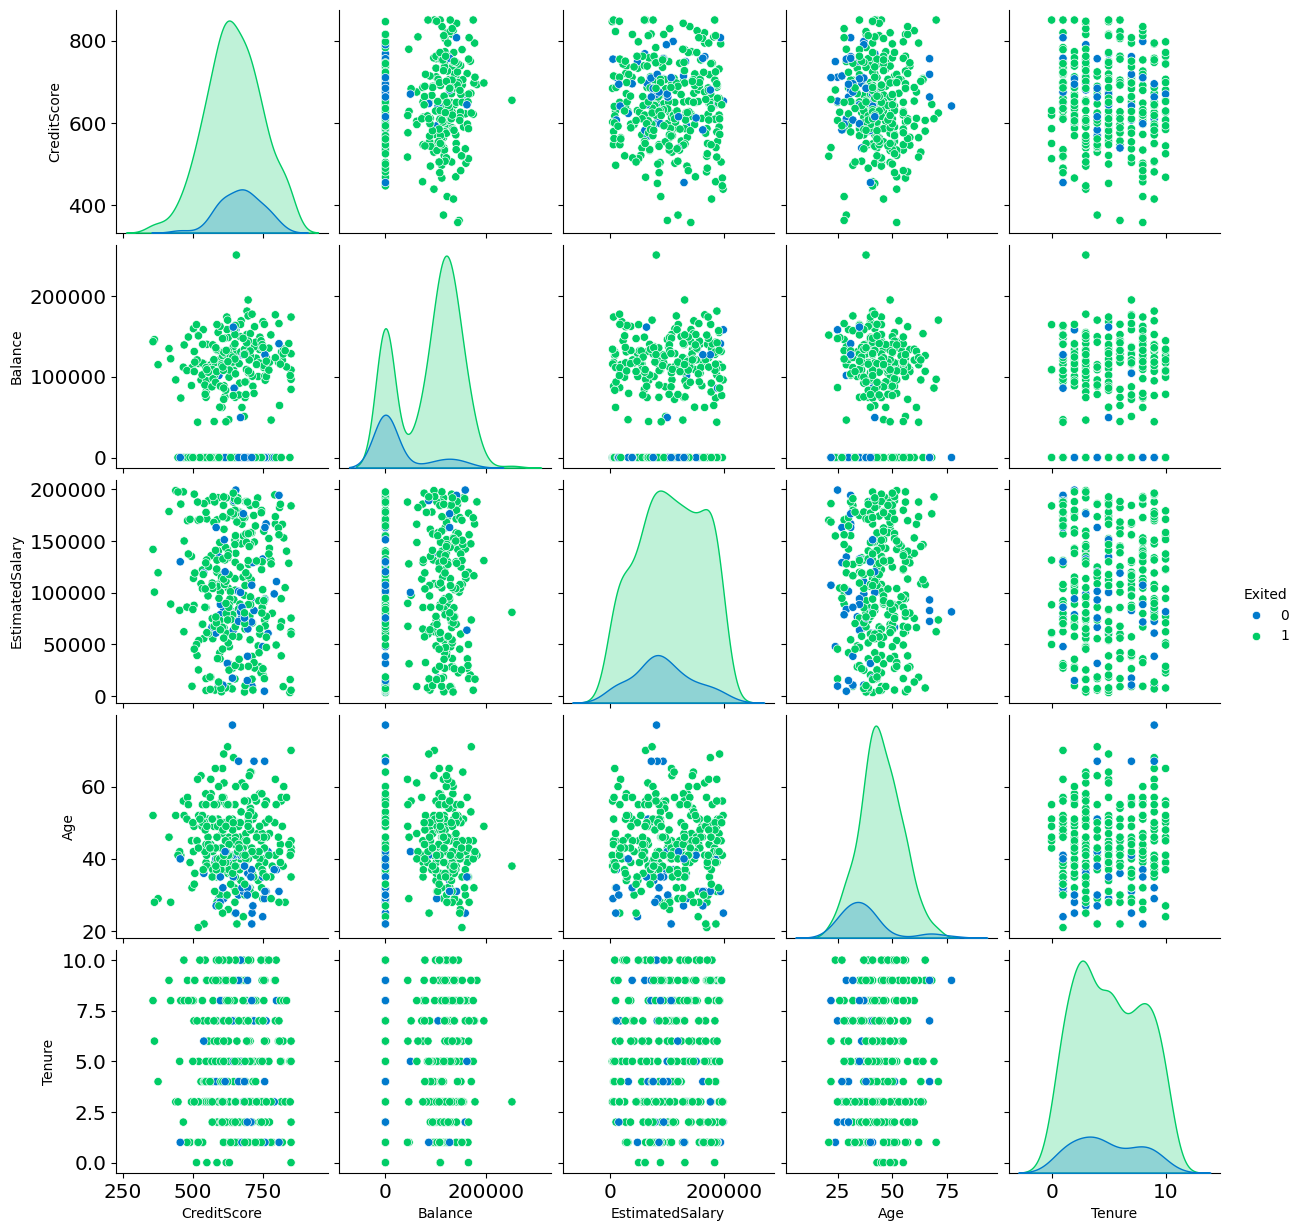

In [23]:
# Membuat DataFrame terpisah untuk NumOfProducts 1 dan 2
df_1_2 = df[df['NumOfProducts'].isin([1, 2])]

# Membuat DataFrame terpisah untuk NumOfProducts 3 dan 4
df_3_4 = df[df['NumOfProducts'].isin([3, 4])]


nums = ['CreditScore', 'Balance', 'EstimatedSalary', 'Age','Exited', 'Tenure']

# Membuat pair plot untuk NumOfProducts 1 dan 2
sns.pairplot(df_1_2[nums], diag_kind='kde' , hue='Exited', palette=warna)
plt.show()

# Membuat pair plot untuk NumOfProducts 3 dan 4
sns.pairplot(df_3_4[nums], diag_kind='kde', hue='Exited', palette=warna)
plt.show()

 Pair Plot dilakukan dengan mengelompokkan num of product 1 dan 2 dengan 3 dan 4, maka terlihat bahwa customer yang menggunakan num of product 3 dan 4 cenderung mengalami churn sedangkan untuk customer yang menggunakan num of product 1 dan 2 cenderung lebih retain atau tidak churn. 

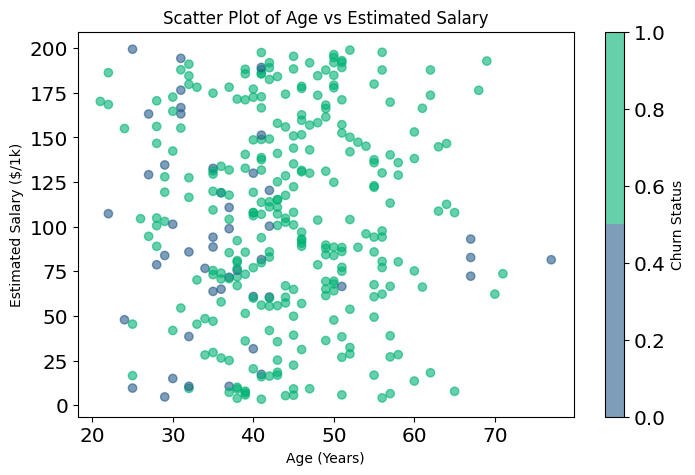

In [24]:
# Membuat colormap dari palet warna sebelumnya
cmap_custom = ListedColormap(palet_warna)

# Membuat scatter plot Age vs Balance dengan palet warna sebelumnya
plt.figure(figsize=(8, 5))
plt.scatter(df_3_4['Age'], df_3_4['EstimatedSalary']/1000, c=df_3_4['Exited'], cmap=cmap_custom, alpha=0.6)
plt.xlabel('Age (Years)')
plt.ylabel('Estimated Salary ($/1k)')
plt.title('Scatter Plot of Age vs Estimated Salary')
plt.colorbar(label='Churn Status')
plt.show()


terlihat jelas pada grafik diatas bahwa pada usia rentang 45 hingga 60 tahun customer cenderung melkaukan churn.

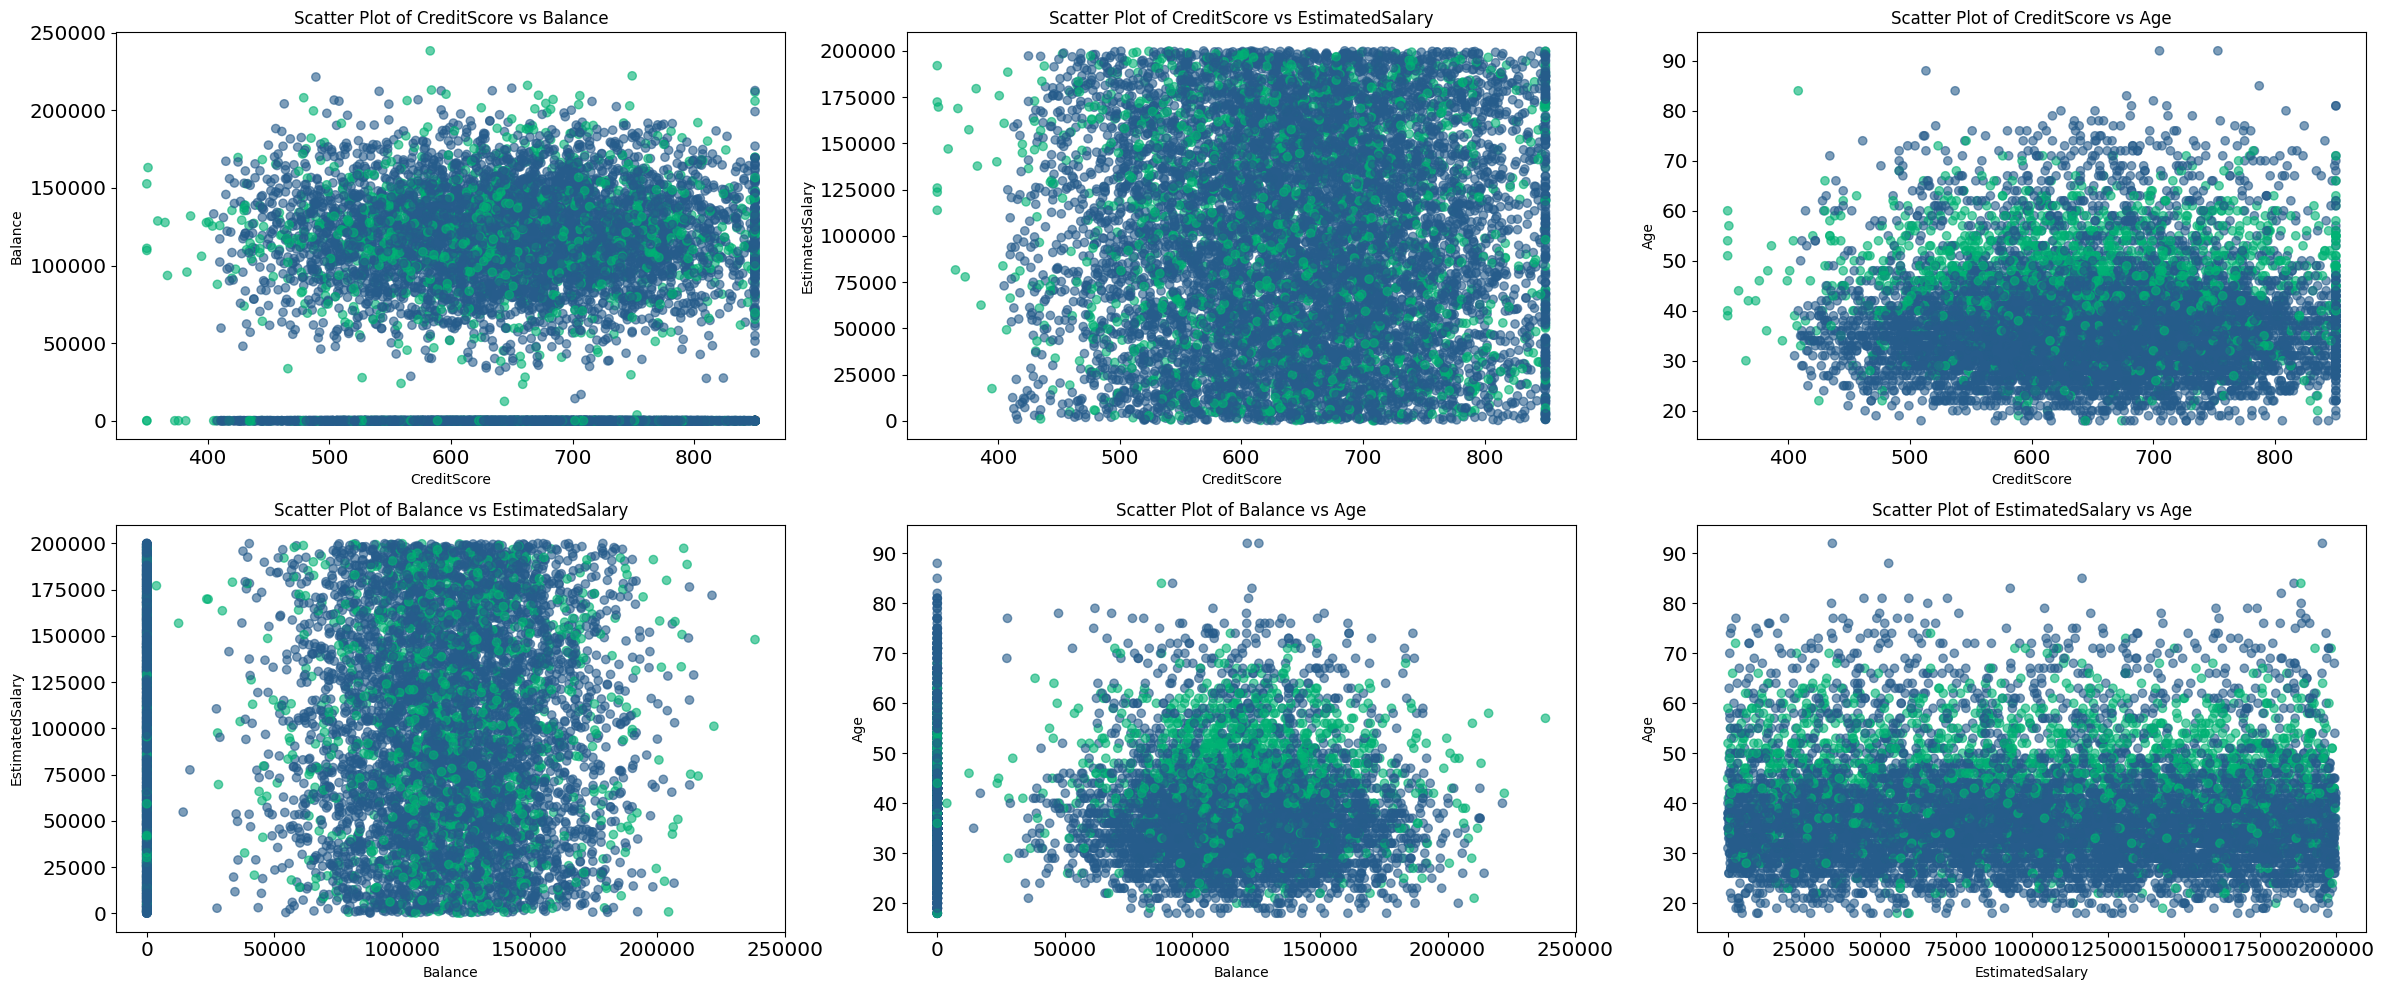

In [25]:

from matplotlib.colors import ListedColormap
# Palet warna yang telah Anda tentukan
palet_warna = ["#265c8b", "#00b274"]

# Membuat colormap kustom
cmap_custom = ListedColormap(palet_warna)

# Tentukan pasangan variabel untuk scatter plot
pairs = [('CreditScore', 'Balance'), ('CreditScore', 'EstimatedSalary'), ('CreditScore', 'Age'),
         ('Balance', 'EstimatedSalary'), ('Balance', 'Age'), ('EstimatedSalary', 'Age')]

# Buat scatter plot untuk setiap pasangan variabel
fig, axs = plt.subplots(2, 3, figsize=(24, 10))

for i, pair in enumerate(pairs):
    row = i // 3
    col = i % 3
    axs[row, col].scatter(df_1_2[pair[0]], df_1_2[pair[1]], c=df_1_2['Exited'], cmap=cmap_custom, alpha=0.6)
    axs[row, col].set_xlabel(pair[0])
    axs[row, col].set_ylabel(pair[1])
    axs[row, col].set_title(f'Scatter Plot of {pair[0]} vs {pair[1]}')

plt.tight_layout()
plt.show()


# Multivariate Analisis

## HeatMap

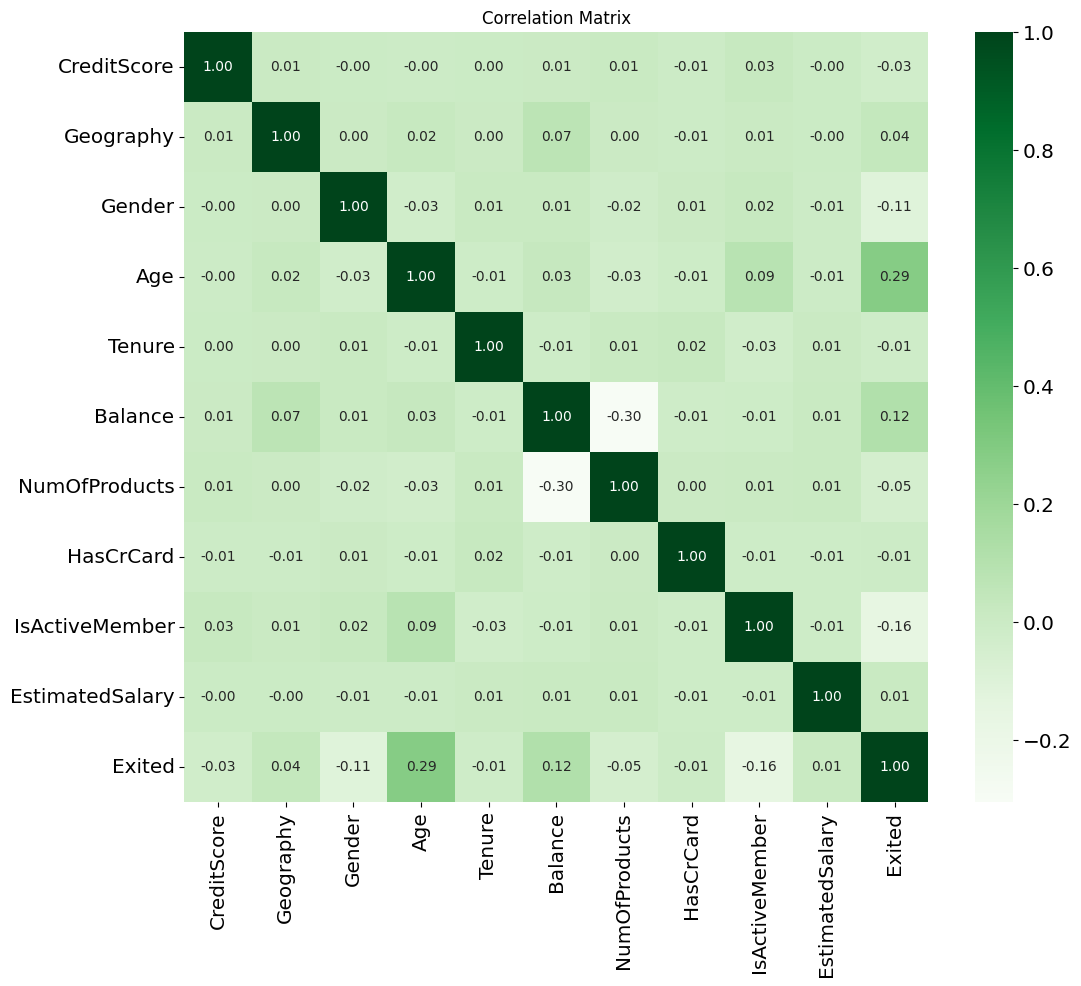

In [26]:
custom_palette = sns.color_palette(['#007acc', '#00cc66'])

# Initialize LabelEncoder
label_encoder = LabelEncoder()

df_heatmap = df.copy()
df_heatmap.drop("AgeGroup", axis=1, inplace=True)
# Convert categorical columns to numerical

df_heatmap['Geography'] = label_encoder.fit_transform(df_heatmap['Geography'])
df_heatmap['Gender'] = label_encoder.fit_transform(df_heatmap['Gender'])

# Calculate correlation matrix
correlation_matrix = df_heatmap.corr()

# Plot the correlation matrix using heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='Greens', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

Berdasarkan Hasil Heatmap, untuk variabel Age dan Balance berkorelasi poisitif dengan variabel Exited, untuk itu perlu dilakukan analisis lebih lanjut. Kami menggunakan Regersi linear berganda untuk mengetahui seberapa besar pengaruh kedua variabel tersebut

# Regresi Linear Berganda

In [27]:
from sklearn.linear_model import LinearRegression
x = df[['Age', 'Balance']]
y = df['Exited']

# Inisialisasi model regresi linear berganda
model = LinearRegression()

# Melatih model menggunakan data
model.fit(x, y)
# Mencetak koefisien regresi
print("Koefisien Regresi (slope):", model.coef_)
print("Intersep Regresi (intercept):", model.intercept_)

Koefisien Regresi (slope): [1.08372290e-02 7.13551809e-07]
Intersep Regresi (intercept): -0.2726811047673484


Bedarasarkan hasil Regresi linear berganda, untuk variabel Age memiliki pengaruh sebesar 0.01 terhadap kemungkinan churn Customer, sedangkan untuk variabel Balance memiliki pengaruh sebesar 0.0000007 terhadap kemungkinan Customer churn

## MENGHILANGKAN OUTLIER

### OUTLIER PADA CREDIT SCORE

In [28]:


# Menghitung IQR untuk 'CreditScore'
Q1 = df['CreditScore'].quantile(0.25)
Q3 = df['CreditScore'].quantile(0.75)
IQR = Q3 - Q1

# Mengidentifikasi outlier
outlier_condition = ((df['CreditScore'] < (Q1 - 1.5 * IQR)) | (df['CreditScore'] > (Q3 + 1.5 * IQR)))

# Menghilangkan outlier
df_no_outliers = df[~outlier_condition]

# Menampilkan deskripsi statistik untuk memeriksa hasilnya
df_no_outliers['CreditScore'].describe()


count    9985.000000
mean      650.963245
std        96.072231
min       383.000000
25%       584.000000
50%       652.000000
75%       718.000000
max       850.000000
Name: CreditScore, dtype: float64

### OUTLIER PADA AGE

In [29]:


# Menghitung IQR untuk 'CreditScore'
Q1 = df['Age'].quantile(0.25)
Q3 = df['Age'].quantile(0.75)
IQR = Q3 - Q1

# Mengidentifikasi outlier
outlier_condition = ((df['Age'] < (Q1 - 1.5 * IQR)) | (df['Age'] > (Q3 + 1.5 * IQR)))

# Menghilangkan outlier
df_no_outliers = df[~outlier_condition]

# Menampilkan deskripsi statistik untuk memeriksa hasilnya
df_no_outliers['Age'].describe()


count    9641.000000
mean       37.791723
std         8.803124
min        18.000000
25%        32.000000
50%        37.000000
75%        43.000000
max        62.000000
Name: Age, dtype: float64

c:\Users\dekdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:1601: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))
c:\Users\dekdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:1601: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))
c:\Users\dekdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:1601: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))
c:\Users\dekdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:1601: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))
c:\Users\dekdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:16

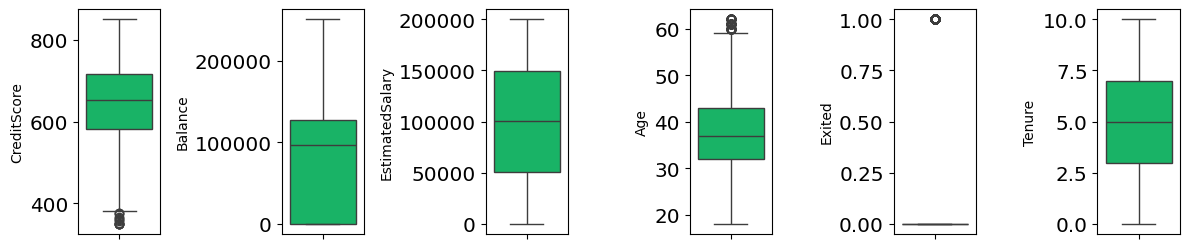

In [30]:

pallet1 = '#00cc66'  # Atau warna spesifik yang Anda inginkan

plt.figure(figsize=(12, 5))
for i in range(0, len(nums)):
    plt.subplot(2, len(nums), i+1)
    sns.boxplot(y=df_no_outliers[nums[i]] ,color=pallet1, orient='h')  
    plt.tight_layout()
plt.show()